In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# 1. Load Dataset
df = pd.read_csv("/content/spam.csv", encoding='latin-1')
df.head()


v1                                                 v2  Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...         NaN   
1   ham                      Ok lar... Joking wif u oni...         NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...         NaN   
3   ham  U dun say so early hor... U c already then say...         NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...         NaN   

   Unnamed: 3  Unnamed: 4  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [ ]:
# 2. Clean Dataset
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0, 'spam':1})

df.head()

label                                               Text  label_enc
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0

In [ ]:
# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42
)

# --- CRITICAL FIX: Convert to NumPy Arrays ---
# Keras 3+ throws "Invalid dtype: object" if you pass Pandas Series directly.
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Calculate stats for vectorization
avg_words_len = round(sum([len(i.split()) for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")

Data Loaded. Training samples: 4457


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Helper function to compile and fit
def compile_and_fit(model, epochs=5):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Using the NumPy arrays (_np) here to prevent errors
    history = model.fit(X_train_np, y_train_np, epochs=epochs,
                        validation_data=(X_test_np, y_test_np))
    return history

# Helper function for metrics
def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1-score': f1_score(y, y_preds)
    }

# --- Text Vectorization Layer ---
from tensorflow.keras.layers import TextVectorization

text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)

# Adapt to the training data (NumPy array)
text_vec.adapt(X_train_np)

In [ ]:
avg_words_len = round(sum([len(i.split())
                      for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(" ".join(df['Text']).split()))

print(f"Data Loaded. Training samples: {len(X_train_np)}")
print(f"Average words per message: {avg_words_len}")
print(f"Approximate vocabulary size: {total_words_length}")


Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


In [ ]:
# Inputs
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Vectorization
x = text_vec(input_layer)

# Embedding (Removed input_length argument)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)

# Architecture
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Compile & Train
model_1 = keras.Model(input_layer, output_layer, name="Dense_Model")
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8476 - loss: 0.3908 - val_accuracy: 0.9614 - val_loss: 0.1377
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9798 - loss: 0.0964 - val_accuracy: 0.9758 - val_loss: 0.0747
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9909 - loss: 0.0361 - val_accuracy: 0.9767 - val_loss: 0.0665
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9950 - loss: 0.0233 - val_accuracy: 0.9794 - val_loss: 0.0716
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9978 - loss: 0.0159 - val_accuracy: 0.9794 - val_loss: 0.0641


In [ ]:
# Inputs
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Vectorization
x = text_vec(input_layer)

# Embedding (Removed input_length argument)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)

# LSTM Layers
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Architecture
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Compile & Train
model_2 = keras.Model(input_layer, output_layer, name="BiLSTM_Model")
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8842 - loss: 0.2986 - val_accuracy: 0.9695 - val_loss: 0.1007
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9826 - loss: 0.0618 - val_accuracy: 0.9821 - val_loss: 0.0659
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.9972 - loss: 0.0128 - val_accuracy: 0.9767 - val_loss: 0.0748
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9987 - loss: 0.0089 - val_accuracy: 0.9776 - val_loss: 0.0925
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9999 - loss: 8.5862e-04 - val_accuracy: 0.9803 - val_loss: 0.1169


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1. Load the Layer
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)

# 2. Build Model using Functional API
# We use shape=[] because USE expects a list of strings (scalars), not a vector of strings
input_layer = layers.Input(shape=[], dtype=tf.string)

# CRITICAL FIX: Add 'output_shape=(512,)'
# We tell Keras: "Trust us, this function will return a vector of size 512"
embedding = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_3 = keras.Model(input_layer, output_layer, name="USE_Model")

# 3. Compile and Train
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8727 - loss: 0.4475 - val_accuracy: 0.9704 - val_loss: 0.1134
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9777 - loss: 0.0883 - val_accuracy: 0.9794 - val_loss: 0.0704
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9841 - loss: 0.0600 - val_accuracy: 0.9839 - val_loss: 0.0612
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9851 - loss: 0.0521 - val_accuracy: 0.9839 - val_loss: 0.0562
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9917 - loss: 0.0355 - val_accuracy: 0.9839 - val_loss: 0.0538


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Performance Table:
                         accuracy  precision    recall  f1-score
Dense Embedding          0.979372   0.963235  0.879195  0.919298
Bi-LSTM                  0.980269   0.970370  0.879195  0.922535
Transfer Learning (USE)  0.983857   0.958042  0.919463  0.938356


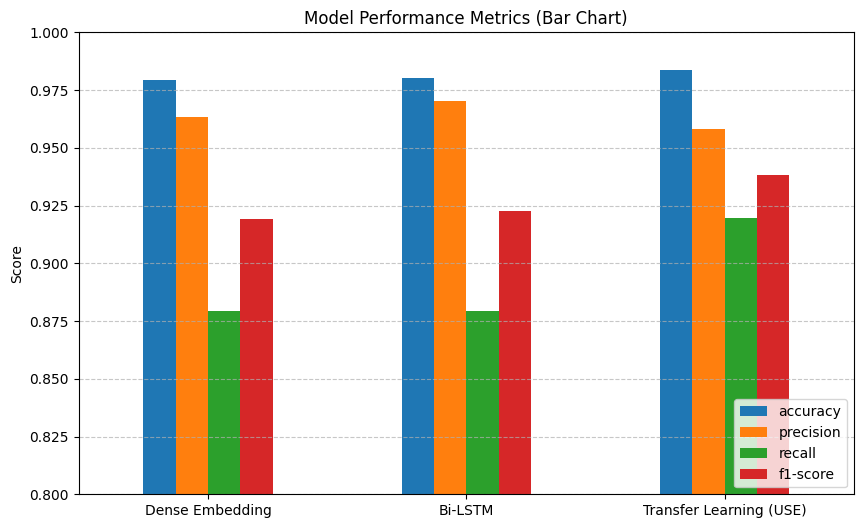

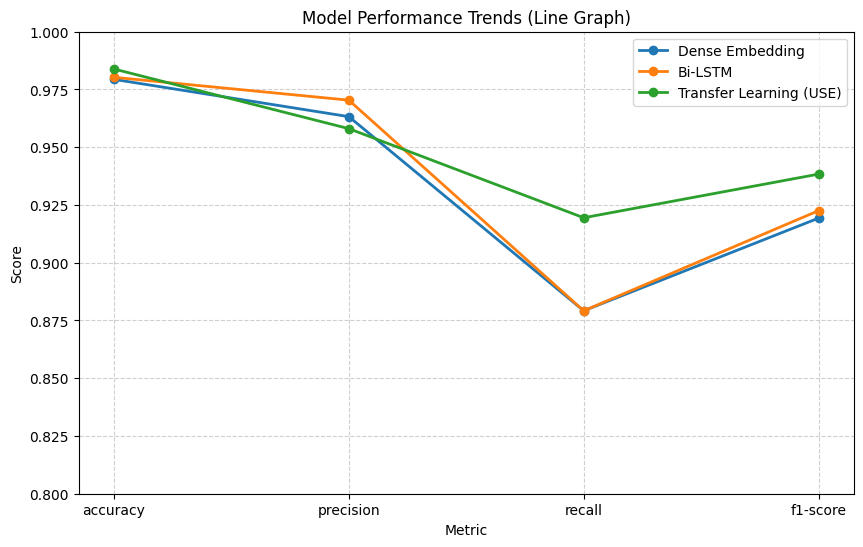

In [ ]:
# ---------------------------------------------------------
# 1. Gather Results
# ---------------------------------------------------------
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np),
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print("Performance Table:")
print(results_df)

# ---------------------------------------------------------
# 2. Bar Chart Comparison
# ---------------------------------------------------------
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0) # Zoom in to see differences
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------------------------------------------------
# 3. Line Graph Comparison
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot a line for each model
# We transpose the DF so X-axis = Metrics, Lines = Models
for model_name in results_df.index:
    plt.plot(results_df.columns, results_df.loc[model_name],
             marker='o', label=model_name, linewidth=2)

plt.title("Model Performance Trends (Line Graph)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.8, 1.0) # Zoom in on the top range
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()